In [131]:
# Importing all needed packages
# Standard packages for data visualization
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt   
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules 
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) # uncomment when you edit the module data_reduction.py
from data_reduction import *

# Other
import datetime
import timeit
from regions import RectanglePixelRegion

# Data reduction of optical spectroscopy
# Task #2: find the Master Flat!

In [127]:
# List of filenames that have been bias-corrected
fnames = glob.glob('not2mattia/*_b.fits*', recursive=True)   
fnames

['not2mattia/ALAe130145_b.fits',
 'not2mattia/ALAe130148_b.fits',
 'not2mattia/ALAe130147_b.fits',
 'not2mattia/ALAe130155_b.fits',
 'not2mattia/ALAe130144_b.fits',
 'not2mattia/ALAe130146_b.fits',
 'not2mattia/ALAe130149_b.fits',
 'not2mattia/ALAe130132_b.fits']

# Flat checks: lamp, high counts and history

In [135]:
# Doing the necessary checks on the flat frames and printing them out

COUNTS_THRESHOLD = 100000
FLAT_PX_PERC_MIN = 50

# Lists of flats: filenames, frames, masks
flat_names = []
flat_frames = []
flat_masks = []

# Choose region of interest, where you compute statistics and model the flat later in the workbook
xmin, xmax, ymin, ymax = 300, 1800, 0, 1500
        
for file in fnames:
    hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
    # An HDU (Header Data Unit) is the highest level component of the FITS file structure, 
    # consisting of a header and (typically) a data array or table.
    
    if hdul[0].header['IMAGETYP'] == 'FLAT,LAMP':
        flat_names.append(file)  # add to the list of flat names
        lamp_type = hdul[0].header['OBJECT']  # to check if Halogen lamp is on
        xdim = hdul[1].header['NAXIS1']  # lenght of x axis
        ydim = hdul[1].header['NAXIS2']  # lenght of y axis
        n_pixels = xdim * ydim  # number of pixels
        
        flat_frames.append(hdul[1].data)  #add to the list of flat frames
        
        # Computing statistics of the pixel values within a window exluding 10% on each side of both axis
        stats = ImageStats("flat_frame_statistics") # define the object where saving the statistics, name is optional
        stats.compute_imstats(hdul[1].data, xmin, xmax, ymin, ymax)
        flat_mean = stats.mean
        flat_median = stats.median
        flat_std = stats.std
        
        # Counting percentage of pixels with lower values than COUNTS_THRESHOLD in the area of interest
        flat_mask_high = stats.counts_of_interest(hdul[1].data, xmin, xmax, ymin, ymax, COUNTS_THRESHOLD)
        flat_masks.append(flat_mask_high)
        flat_pixel_percentage = stats.px_perc
        
        # Checking that the master bias has been subtracted
        bias_check = hdul[0].header['HISTORY'] # will be printed below, check for each frame! 
        
        print(file, " lamp =", lamp_type, " frame =", xdim, "x", ydim, "nPixels =", n_pixels)
        print("Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) =", xmin, xmax, ymin, ymax)
        print("Image statistics: mean =", flat_mean, " median =", flat_median, " std =", flat_std)
        print("In the region of interest",  "{:.2f}".format(flat_pixel_percentage), 
              "% of the pixels have a value higher than", COUNTS_THRESHOLD)
        print("HISTORY: ", bias_check)
        
        if flat_pixel_percentage < FLAT_PX_PERC_MIN: 
            print("\nWARNING: the percentage of pixles with a value lower than", COUNTS_THRESHOLD, 
                  "is lower than ", FLAT_PX_PERC_MIN, "%\n"
                  "Please choose a more representative area of interest.")
            
        print("")
    hdul.close()

flat_array = np.array(flat_frames)
flat_masks_array = np.array(flat_masks)

not2mattia/ALAe130148_b.fits  lamp = Halogen 2 Flat AT2017dtj  frame = 2148 x 2102 nPixels = 4515096
Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) = 300 1800 0 1500
Image statistics: mean = 112355.98945857912  median = 112355.98945857912  std = 65133.6429082305
In the region of interest 54.54 % of the pixels have a value higher than 100000
HISTORY:  Master Bias subtracted on 2020-11-17 16:10:42 using master bias file not
2mattia/master_bias_average.fits

not2mattia/ALAe130147_b.fits  lamp = Halogen 1 Flat AT2017dtj  frame = 2148 x 2102 nPixels = 4515096
Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) = 300 1800 0 1500
Image statistics: mean = 113450.77512480134  median = 113450.77512480134  std = 65552.00103641904
In the region of interest 55.05 % of the pixels have a value higher than 100000
HISTORY:  Master Bias subtracted on 2020-11-17 16:10:42 using master bias file not
2mattia/master_bias_average.fits

not2mattia/ALAe130149_b.fits  lamp = Halogen 3 

# Plot of a flat frame and the region of interest

<IPython.core.display.Javascript object>


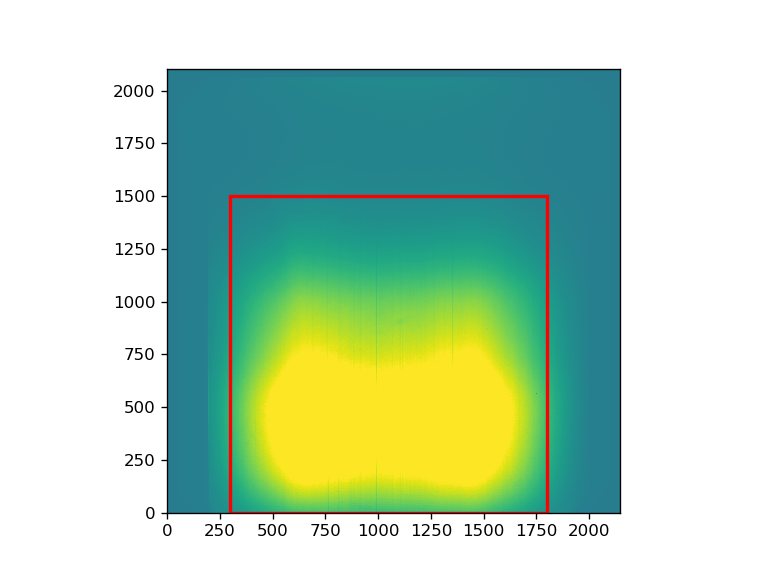

<IPython.core.display.Javascript object>


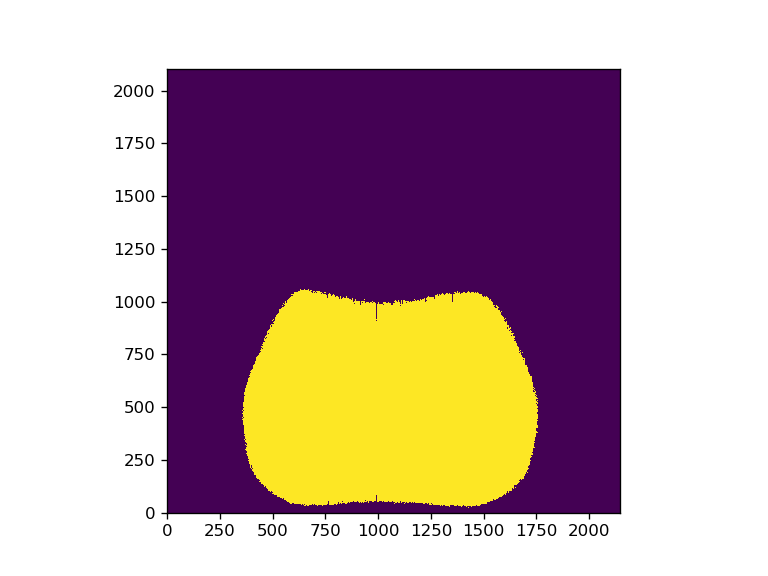

In [134]:
# Plotting one flat frame as an example (highlighting the region of interest) and one mask for high counts
# flat frame
b = flat_array[0]
fig, ax = plt.subplots(1, 1)
ax.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

# rectangle of interest
center = PixCoord((xmin+xmax)/2, (ymin+ymax)/2)
width = xmax-xmin
height = ymax-ymin
reg = RectanglePixelRegion(center=center, width=width, height=height)
patch = reg.as_artist(facecolor='none', edgecolor='red', lw=2)
ax.add_patch(patch)

# high-counts mask
plt.figure()
c = flat_masks_array[0]
c.reshape(b.shape)
plt.imshow(c, origin='lower')

# Fitting a 2D Polynomial

/home/masi1109/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


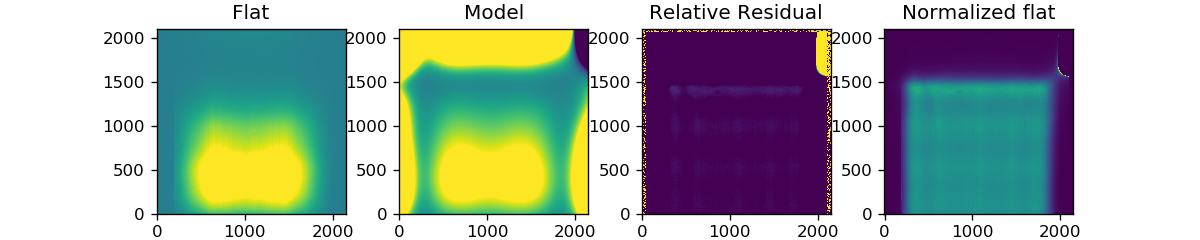

2D Polynomial fit of the region of interest...
Normalized flat frame created with shape  (2102, 2148)


<IPython.core.display.Javascript object>


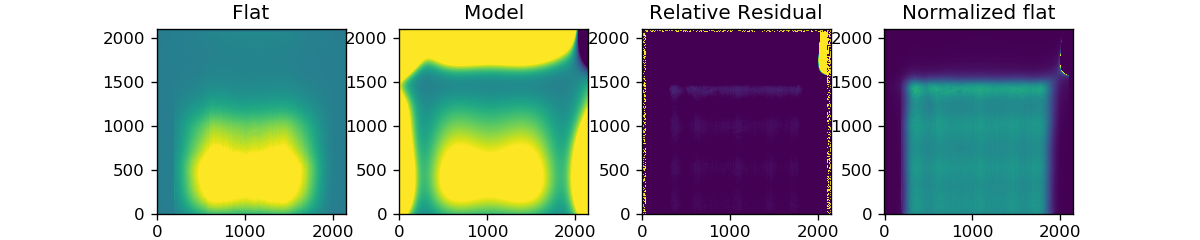

2D Polynomial fit of the region of interest...
Normalized flat frame created with shape  (2102, 2148)


<IPython.core.display.Javascript object>


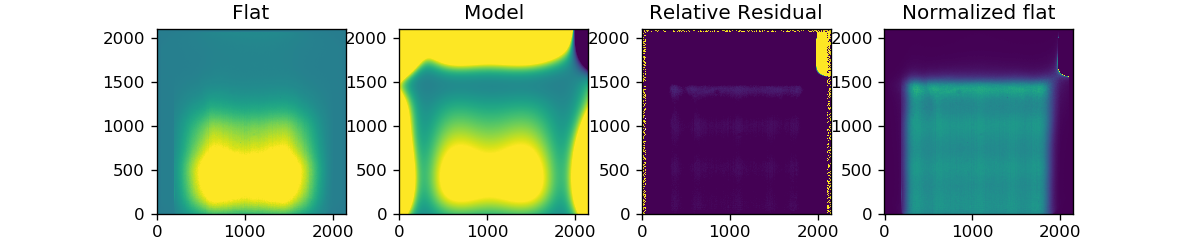

2D Polynomial fit of the region of interest...
Normalized flat frame created with shape  (2102, 2148)

Total time taken for modeling the flat frames:  18.49 seconds
Time per frame:  6.16


In [141]:
# Fitting each flat frame with a 2d polynomial
from scipy import interpolate
import warnings
from astropy.modeling import models, fitting

# If you want to adjust region of interest where to model the flats:
xmin, xmax, ymin, ymax = 300, 1800, 0, 1500

norm_flat_array = [] # define array of normalized flat frames

# Measure time for modeling the flat
start_time = timeit.default_timer()

for flat in flat_array:

    x, y = np.mgrid[xmin:xmax,ymin:ymax] # define grid for the region of interest
    z = np.transpose(flat[ymin:ymax,xmin:xmax]) # frame data: y-axis is the first and x-axis is the second  

    #p_init = models.Polynomial2D(degree=7)
    p_init = models.Chebyshev2D(x_degree=7, y_degree=7)    # for a better fit use Chebyshev Polynomials
    fit_p = fitting.LinearLSQFitter()
    p = fit_p(p_init, x, y, z) # fitting the region of interest
    
    x_frame, y_frame = np.mgrid[0:xdim, 0:ydim] # define grid for the whole frame
    poly = np.transpose(p(x_frame, y_frame)) # go back to axis order of original matrix 
    resid_rel = (flat - poly) / flat
    norm = flat / poly

    # Plot data, model, residual and normalized frame
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 4, 1)
    plt.imshow(flat, origin='lower', vmin=np.median(flat)-2*np.std(flat), vmax=np.median(flat)+2*np.std(flat))
    plt.title("Flat")
    plt.subplot(1, 4, 2)
    plt.imshow(poly, origin='lower', vmin=np.median(flat)-2*np.std(flat), vmax=np.median(flat)+2*np.std(flat))
    plt.title("Model")
    plt.subplot(1, 4, 3)
    plt.imshow(resid_rel, origin='lower', vmin=0, vmax=2)
    plt.title("Relative Residual")
    plt.subplot(1, 4, 4)
    plt.imshow(norm, origin='lower', vmin=0, vmax=2)
    plt.title("Normalized flat")
    
    norm_flat_array.append(norm)
    
    print("2D Polynomial fit of the region of interest...")
    print("Normalized flat frame created with shape ", norm.shape)
          
elapsed = timeit.default_timer() - start_time
print("\nTotal time taken for modeling the flat frames: ", "{:.2f}".format(elapsed), "seconds")
print("Time per frame: ", "{:.2f}".format(elapsed / len(flat_array)))

# Combining the normalized flat frames into the Master Flat

<IPython.core.display.Javascript object>


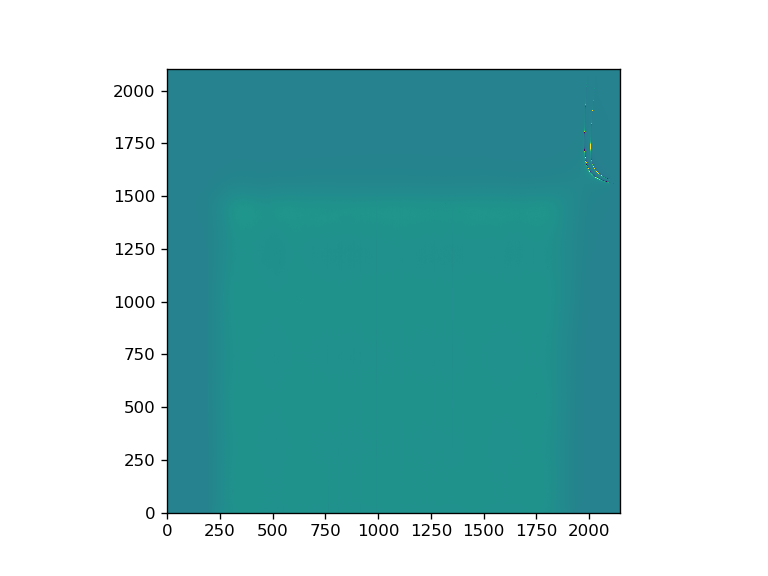

<IPython.core.display.Javascript object>


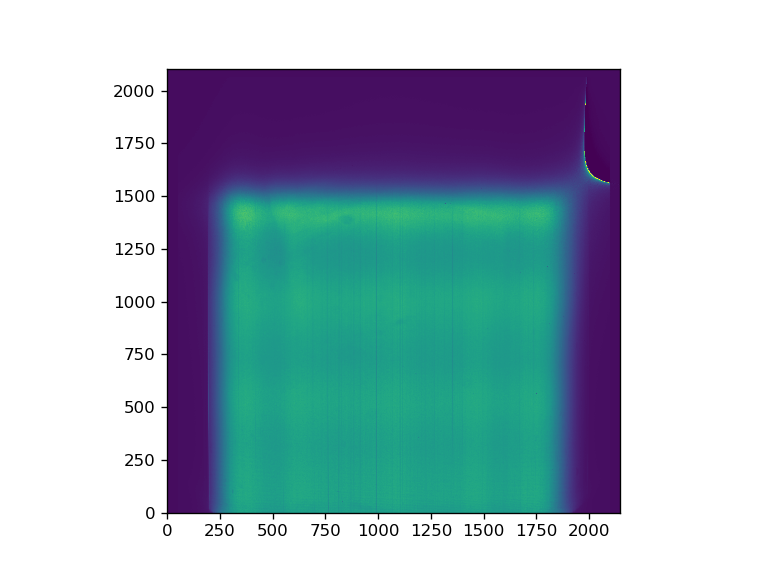

In [112]:
# Computing the master flat using a function defined in data_reduction.py module
# Two methods of combination are available: (1) mean or (2) median

# need norm_flat_array

master_flat1 = get_master(norm_flat_array, method="mean", n_clip=2)
master_flat2 = get_master(norm_flat_array, method="median", n_clip=2)

b = master_flat1
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

c = master_flat2
plt.figure()
plt.imshow(c, origin='lower', vmin=np.median(c)-2*np.std(c), vmax =np.median(c)+2*np.std(c))

# Creating a fits file for the master flat obtained with the average
hdu = fits.ImageHDU(master_flat1)

hdr = fits.Header()
now = datetime.datetime.now()
now_string = now.strftime("%Y-%m-%d %H:%M:%S")
hdr['COMMENT'] = "Master flat frame (average of flat frames) obtained on " + now_string
hdr['IMAGETYP'] = 'MASTER FLAT'
empty_primary = fits.PrimaryHDU(header=hdr)

hdul = fits.HDUList([empty_primary, hdu])
hdul.writeto('not2mattia/master_flat_mean.fits', overwrite=True)

# Dividing the object frames by the Master Flat

In [113]:
# Subtracting the master flat (mean) from all other frames that are not flat frames

hdul_master = fits.open('not2mattia/master_flat_mean.fits')

for file in fnames:
    hdul = fits.open(file)
    
    if 'FLAT_DIV' in hdul[0].header:  # if flat has been divided already we skip to the next frame
        continue 
    
    imtyp = hdul[0].header['IMAGETYP']
    if imtyp == 'WAVE,LAMP' or imtyp == 'OBJECT':
        
        hdul[1].data = hdul[1].data / hdul_master[1].data
        print("Master flat divided, frame", file, "of image type:", hdul[0].header['IMAGETYP'])
        
        comment = "Master flat divided on: "
        now = datetime.datetime.now()
        comment += now.strftime("%Y-%m-%d %H:%M:%S")
        comment += " using master flat file " + 'not2mattia/master_flat_mean.fits'        
        hdul[0].header['HISTORY'] = comment
        hdul[0].header['COMMENT'] = comment
        hdul[0].header['FLAT_DIV'] = 'Yes'
        
        new_file_name = file.replace(".fits", "_f.fits")
        hdul.writeto(new_file_name, overwrite=True)
        print("New fits file created for the flat-normalized frame:", new_file_name, "\n")
    
    hdul.close()

hdul_master.close()

Master flat divided, frame not2mattia/ALAe130145_b.fits of image type: OBJECT
New fits file created for the flat-normalized frame: not2mattia/ALAe130145_b_f.fits 

Master flat divided, frame not2mattia/ALAe130155_b.fits of image type: OBJECT
New fits file created for the flat-normalized frame: not2mattia/ALAe130155_b_f.fits 

Master flat divided, frame not2mattia/ALAe130144_b.fits of image type: OBJECT
New fits file created for the flat-normalized frame: not2mattia/ALAe130144_b_f.fits 

Master flat divided, frame not2mattia/ALAe130146_b.fits of image type: WAVE,LAMP
New fits file created for the flat-normalized frame: not2mattia/ALAe130146_b_f.fits 

Master flat divided, frame not2mattia/ALAe130132_b.fits of image type: OBJECT
New fits file created for the flat-normalized frame: not2mattia/ALAe130132_b_f.fits 

